# Регрессия для предсказания `outcome`

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score,
)

from sklearn.metrics import (
    roc_auc_score,
)
from sklearn.ensemble import RandomForestClassifier
import random

pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")

Для основных распределений датасета, см. `l1.ipynb`

In [16]:
path = "dataset/horse.csv"
df = pd.read_csv(path)
print(df.shape)
df.head()

(299, 28)


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


## Бейзлайн без подбора гиперпараметров

### Бейзлайн датасет

In [17]:
X = df.drop(columns=["outcome"])
y = df["outcome"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Тренериуем бейзлайн

In [18]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_pipe = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    [("num", numeric_pipe, num_cols), ("cat", categorical_pipe, cat_cols)]
)

rf_base = RandomForestClassifier(random_state=42, n_estimators=100)
model_base = Pipeline([("preprocess", preprocess), ("clf", rf_base)])
model_base.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Оценка бейзлайна на тестовой выборке

In [19]:
y_pred = model_base.predict(X_test)
y_pred_proba = model_base.predict_proba(X_test)[:, 1]

acc_base = accuracy_score(y_test, y_pred)
f1_base = f1_score(y_test, y_pred, average="macro")

print("Accuracy:", acc_base)
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6666666666666666

Classification report:
               precision    recall  f1-score   support

        died       0.56      0.60      0.58        15
  euthanized       0.67      0.22      0.33         9
       lived       0.71      0.81      0.75        36

    accuracy                           0.67        60
   macro avg       0.65      0.54      0.56        60
weighted avg       0.67      0.67      0.65        60



### Тепловая карта confusion matrix

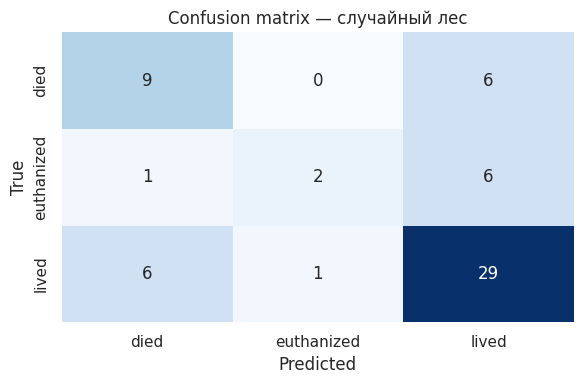

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=model_base.classes_)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=model_base.classes_,
    yticklabels=model_base.classes_,
    ax=axes,
)
axes.set_xlabel("Predicted")
axes.set_ylabel("True")
axes.set_title("Confusion matrix — случайный лес")

plt.tight_layout()
plt.show()


## Улучшение бейзлайна для классификации
1. Сделать gridsearch
2. Использовать метрику f1_macro для многоклассовой классификации

### Подготовка улучшенного датасета


In [21]:
missing_thresh = 0.7
missing_pct = df.isna().mean()
high_na_cols = missing_pct[missing_pct > missing_thresh].index.tolist()

print(f"Колонки, удалённые по порогу пропусков ({missing_thresh * 100}%):")
for col in high_na_cols:
    print(f"  - {col}: {missing_pct[col] * 100:.1f}% пропусков")

df_imp = df.drop(columns=high_na_cols)

X_imp = df_imp.drop(columns=["outcome"])
y_imp = df_imp["outcome"]

cat_cols_imp = X_imp.select_dtypes(include=["object"]).columns.tolist()
num_cols_imp = [c for c in X_imp.columns if c not in cat_cols_imp]

print(
    f"\nОсталось признаков: {X_imp.shape[1]} ({len(num_cols_imp)} числовых, {len(cat_cols_imp)} категориальных)"
)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imp, y_imp, test_size=0.2, random_state=42, stratify=y_imp
)


Колонки, удалённые по порогу пропусков (70.0%):
  - nasogastric_reflux_ph: 82.3% пропусков

Осталось признаков: 26 (10 числовых, 16 категориальных)


### Подбор гиперпараметров для классфикации


In [22]:
numeric_pipe_imp = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_pipe_imp = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocess_imp = ColumnTransformer(
    [
        ("num", numeric_pipe_imp, num_cols_imp),
        ("cat", categorical_pipe_imp, cat_cols_imp),
    ]
)

rf_imp = RandomForestClassifier(random_state=1337)

model_imp = Pipeline([("preprocess", preprocess_imp), ("clf", rf_imp)])

param_grid_imp = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [5, 10, 15, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__class_weight": [None, "balanced", "balanced_subsample"],
}

print("\nЗапуск GridSearchCV для подбора гиперпараметров...")
print(
    f"Количество комбинаций: {len(param_grid_imp['clf__n_estimators']) * len(param_grid_imp['clf__max_depth']) * len(param_grid_imp['clf__min_samples_split']) * len(param_grid_imp['clf__min_samples_leaf']) * len(param_grid_imp['clf__class_weight'])}"
)

gs_imp = GridSearchCV(
    model_imp, param_grid_imp, cv=5, scoring="f1_macro", n_jobs=-1, verbose=1
)

gs_imp.fit(X_train_imp, y_train_imp)

print(f"Лучший f1_macro (кросс-валидация): {gs_imp.best_score_:.4f}")
print(f"Лучшие параметры: {gs_imp.best_params_}")

best_model_imp = gs_imp.best_estimator_



Запуск GridSearchCV для подбора гиперпараметров...
Количество комбинаций: 324
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Лучший f1_macro (кросс-валидация): 0.6490
Лучшие параметры: {'clf__class_weight': 'balanced_subsample', 'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}


### Оценка улучшенной модели на тестовой выборке


In [23]:
y_pred_imp = best_model_imp.predict(X_test_imp)
y_pred_proba_imp = best_model_imp.predict_proba(X_test_imp)

acc_imp = accuracy_score(y_test_imp, y_pred_imp)
f1_imp = f1_score(y_test_imp, y_pred_imp, average="macro")

print(f"Accuracy: {acc_imp:.4f}")
print(f"F1-macro: {f1_imp:.4f}")
print("\nClassification report (3 класса):")
print(classification_report(y_test_imp, y_pred_imp))


auc_scores = {}
for i, class_label in enumerate(best_model_imp.classes_):
    auc = roc_auc_score((y_test_imp == class_label).astype(int), y_pred_proba_imp[:, i])
    auc_scores[class_label] = auc
print("\nAUC-ROC (One-vs-Rest):")
for class_label, auc in auc_scores.items():
    print(f"  Класс {class_label}: {auc:.4f}")
print(f"  Средний AUC: {np.mean(list(auc_scores.values())):.4f}")


Accuracy: 0.6667
F1-macro: 0.5955

Classification report (3 класса):
              precision    recall  f1-score   support

        died       0.57      0.87      0.68        15
  euthanized       0.43      0.33      0.38         9
       lived       0.80      0.67      0.73        36

    accuracy                           0.67        60
   macro avg       0.60      0.62      0.60        60
weighted avg       0.69      0.67      0.66        60


AUC-ROC (One-vs-Rest):
  Класс died: 0.8815
  Класс euthanized: 0.8017
  Класс lived: 0.7465
  Средний AUC: 0.8099


### Визуализация результатов


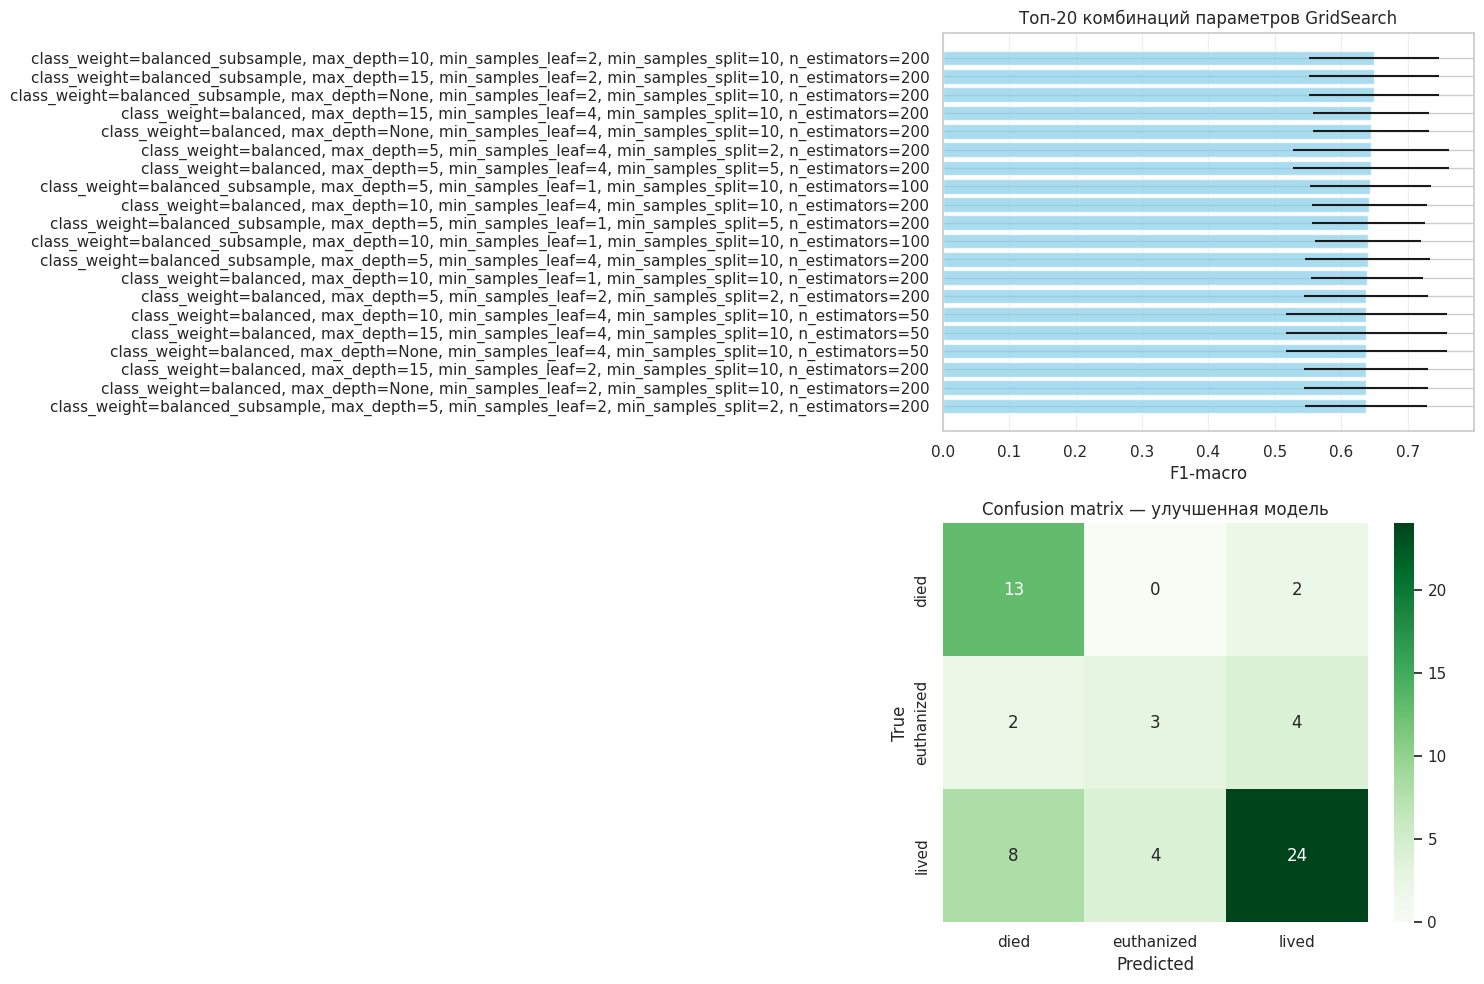


Результаты GridSearch:
   - Лучшая конфигурация: {'clf__class_weight': 'balanced_subsample', 'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}
   - Лучший F1-macro (CV): 0.6490

Производительность на тесте:
   - Accuracy: 0.6667
   - F1-macro: 0.5955

Улучшение по сравнению с бейзлайном:
   - Accuracy: +0.0%
   - F1-macro: +7.2%


In [24]:
fig, axes = plt.subplots(2, figsize=(15, 10))

cv_res_imp = pd.DataFrame(gs_imp.cv_results_)

top_results = cv_res_imp.nsmallest(20, "rank_test_score")[
    ["params", "mean_test_score", "std_test_score"]
].copy()


def params_to_str(params_dict):
    return ", ".join([f"{k.split('__')[-1]}={v}" for k, v in params_dict.items()])


top_results["params_str"] = top_results["params"].apply(params_to_str)

axes[0].barh(
    range(len(top_results)),
    top_results["mean_test_score"],
    xerr=top_results["std_test_score"],
    alpha=0.7,
    color="skyblue",
)
axes[0].set_yticks(range(len(top_results)))
axes[0].set_yticklabels(top_results["params_str"])
axes[0].set_xlabel("F1-macro")
axes[0].set_title("Топ-20 комбинаций параметров GridSearch")
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis="x")

cm_imp = confusion_matrix(y_test_imp, y_pred_imp, labels=best_model_imp.classes_)
sns.heatmap(
    cm_imp,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=True,
    xticklabels=best_model_imp.classes_,
    yticklabels=best_model_imp.classes_,
    ax=axes[1],
)
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Confusion matrix — улучшенная модель")

plt.tight_layout()
plt.show()


print("\nРезультаты GridSearch:")
print(f"   - Лучшая конфигурация: {gs_imp.best_params_}")
print(f"   - Лучший F1-macro (CV): {gs_imp.best_score_:.4f}")

print("\nПроизводительность на тесте:")
print(f"   - Accuracy: {acc_imp:.4f}")
print(f"   - F1-macro: {f1_imp:.4f}")

improvement_acc = (acc_imp - acc_base) / acc_base * 100
improvement_f1 = (f1_imp - f1_base) / f1_base * 100
print("\nУлучшение по сравнению с бейзлайном:")
print(f"   - Accuracy: +{improvement_acc:.1f}%")
print(f"   - F1-macro: +{improvement_f1:.1f}%")

## Собственная имплементация

In [25]:
class CustomDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        criterion="gini",
        random_state=None,
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.random_state = random_state

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return 1 - np.sum(probabilities**2)

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))

    def _information_gain(self, y, y_left, y_right):
        n = len(y)
        n_left = len(y_left)
        n_right = len(y_right)

        if self.criterion == "gini":
            parent_impurity = self._gini(y)
            left_impurity = self._gini(y_left)
            right_impurity = self._gini(y_right)
        else:
            parent_impurity = self._entropy(y)
            left_impurity = self._entropy(y_left)
            right_impurity = self._entropy(y_right)

        return parent_impurity - (
            n_left / n * left_impurity + n_right / n * right_impurity
        )

    def _find_best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        n_samples, n_features = X.shape

        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]

            unique_values = np.unique(feature_values)

            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i + 1]) / 2

                left_mask = feature_values <= threshold
                right_mask = ~left_mask

                if (
                    len(y[left_mask]) < self.min_samples_leaf
                    or len(y[right_mask]) < self.min_samples_leaf
                ):
                    continue

                gain = self._information_gain(y, y[left_mask], y[right_mask])

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _create_leaf_node(self, y, n_samples):
        class_counts = {}
        for cls in self.classes_:
            class_counts[cls] = np.sum(y == cls)
        total = sum(class_counts.values())
        probabilities = {cls: count / total for cls, count in class_counts.items()}
        predicted_class = max(class_counts, key=class_counts.get)

        return {
            "type": "leaf",
            "class": predicted_class,
            "probabilities": probabilities,
            "samples": n_samples,
        }

    def _build_tree(self, X, y, depth=0):
        n_samples = len(y)
        unique_classes = np.unique(y)

        if (
            (self.max_depth is not None and depth >= self.max_depth)
            or n_samples < self.min_samples_split
            or len(unique_classes) == 1
        ):
            return self._create_leaf_node(y, n_samples)

        best_feature, best_threshold, best_gain = self._find_best_split(X, y)

        if best_feature is None or best_gain < 1e-10:
            return self._create_leaf_node(y, n_samples)

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {
            "type": "node",
            "feature": best_feature,
            "threshold": best_threshold,
            "gain": best_gain,
            "left": left_subtree,
            "right": right_subtree,
            "samples": n_samples,
        }

    def fit(self, X, y):
        if self.random_state is not None:
            random.seed(self.random_state)
            np.random.seed(self.random_state)

        X = np.asarray(X)
        y = np.asarray(y)

        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        self.n_features_ = X.shape[1]

        self.tree_ = self._build_tree(X, y)
        self.n_nodes_ = self._count_nodes(self.tree_)

        return self

    def _count_nodes(self, node):
        if node["type"] == "leaf":
            return 1
        return 1 + self._count_nodes(node["left"]) + self._count_nodes(node["right"])

    def _predict_sample(self, x, node):
        if node["type"] == "leaf":
            return node["class"], node["probabilities"]

        if x[node["feature"]] <= node["threshold"]:
            return self._predict_sample(x, node["left"])
        else:
            return self._predict_sample(x, node["right"])

    def predict(self, X):
        X = np.asarray(X)
        predictions = []
        for sample in X:
            pred_class, _ = self._predict_sample(sample, self.tree_)
            predictions.append(pred_class)
        return np.array(predictions)

    def predict_proba(self, X):
        X = np.asarray(X)
        probabilities = []
        for sample in X:
            _, probs = self._predict_sample(sample, self.tree_)
            prob_array = [probs.get(cls, 0) for cls in self.classes_]
            probabilities.append(prob_array)
        return np.array(probabilities)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


class CustomRandomForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        random_state=None,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices_list = []
        self.classes_ = None
        self.n_features_ = None

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def _get_random_features(self, n_features):
        if isinstance(self.max_features, str):
            if self.max_features == "sqrt":
                n_features_to_select = int(np.sqrt(n_features))
            elif self.max_features == "log2":
                n_features_to_select = int(np.log2(n_features) + 1)
            else:
                n_features_to_select = n_features
        elif isinstance(self.max_features, float):
            n_features_to_select = int(self.max_features * n_features)
        else:
            n_features_to_select = self.max_features

        n_features_to_select = max(1, min(n_features_to_select, n_features))
        return np.random.choice(n_features, n_features_to_select, replace=False)

    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        X = np.asarray(X)
        y = np.asarray(y)

        self.classes_ = np.unique(y)
        self.n_features_ = X.shape[1]

        self.trees = []
        self.feature_indices_list = []

        for i in range(self.n_estimators):
            X_boot, y_boot = self._bootstrap_sample(X, y)

            feature_indices = self._get_random_features(self.n_features_)

            tree = CustomDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state + i if self.random_state else None,
            )

            tree.fit(X_boot[:, feature_indices], y_boot)

            self.trees.append(tree)
            self.feature_indices_list.append(feature_indices)

        return self

    def predict(self, X):
        X = np.asarray(X)

        all_predictions = []
        for tree, feature_indices in zip(self.trees, self.feature_indices_list):
            predictions = tree.predict(X[:, feature_indices])
            all_predictions.append(predictions)

        all_predictions = np.array(all_predictions)

        final_predictions = []
        for i in range(X.shape[0]):
            sample_predictions = all_predictions[:, i]
            values, counts = np.unique(sample_predictions, return_counts=True)
            final_predictions.append(values[np.argmax(counts)])

        return np.array(final_predictions)

    def predict_proba(self, X):
        X = np.asarray(X)

        proba = np.zeros((X.shape[0], len(self.classes_)))

        for tree, feature_indices in zip(self.trees, self.feature_indices_list):
            tree_proba = tree.predict_proba(X[:, feature_indices])
            proba += tree_proba

        proba /= self.n_estimators

        return proba

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

Применяем собственный RF на исходных данных.


In [26]:
preprocess.fit(X_train)
X_train_base_t = preprocess.transform(X_train)
X_test_base_t = preprocess.transform(X_test)

rf_custom = CustomRandomForestClassifier(n_estimators=100, random_state=42)
rf_custom.fit(X_train_base_t, y_train)
y_pred_custom = rf_custom.predict(X_test_base_t)

In [27]:
acc_custom = accuracy_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom, average="macro")

print("Custom RF Accuracy (base data):", acc_custom)
print("Custom RF F1-macro (base data):", f1_custom)
print("\nClassification report:\n", classification_report(y_test, y_pred_custom))

Custom RF Accuracy (base data): 0.6666666666666666
Custom RF F1-macro (base data): 0.44115226337448554

Classification report:
               precision    recall  f1-score   support

        died       0.53      0.53      0.53        15
  euthanized       0.00      0.00      0.00         9
       lived       0.71      0.89      0.79        36

    accuracy                           0.67        60
   macro avg       0.41      0.47      0.44        60
weighted avg       0.56      0.67      0.61        60



/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

Confusion matrtix для собственного бейзлайна

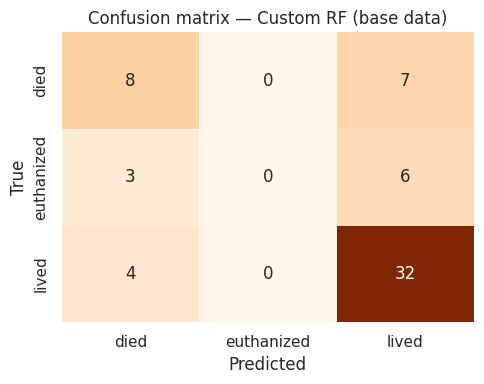

In [28]:
cm_custom = confusion_matrix(y_test, y_pred_custom, labels=model_base.classes_)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm_custom,
    annot=True,
    fmt="d",
    cmap="Oranges",
    cbar=False,
    xticklabels=model_base.classes_,
    yticklabels=model_base.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — Custom RF (base data)")
plt.tight_layout()
plt.show()


Custom RF на улучшенных данных (используем лучшие параметры из GridSearch).

In [29]:
preprocess_imp.fit(X_train_imp)
X_train_imp_t = preprocess_imp.transform(X_train_imp)
X_test_imp_t = preprocess_imp.transform(X_test_imp)

best_n_estimators = gs_imp.best_params_.get("clf__n_estimators", 100)
best_max_depth = gs_imp.best_params_.get("clf__max_depth", None)
best_min_samples_split = gs_imp.best_params_.get("clf__min_samples_split", 2)
best_min_samples_leaf = gs_imp.best_params_.get("clf__min_samples_leaf", 1)
best_class_weight = gs_imp.best_params_.get("clf__class_weight", None)

custom_rf_imp = CustomRandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=12,
)
custom_rf_imp.fit(X_train_imp_t, y_train_imp)
y_pred_custom_imp = custom_rf_imp.predict(X_test_imp_t)

acc_custom_imp = accuracy_score(y_test_imp, y_pred_custom_imp)
f1_custom_imp = f1_score(y_test_imp, y_pred_custom_imp, average="macro")

print("Custom RandomForest (improved) Accuracy:", acc_custom_imp)
print("Custom RandomForest (improved) F1-macro:", f1_custom_imp)

Custom RandomForest (improved) Accuracy: 0.65
Custom RandomForest (improved) F1-macro: 0.4282700421940928


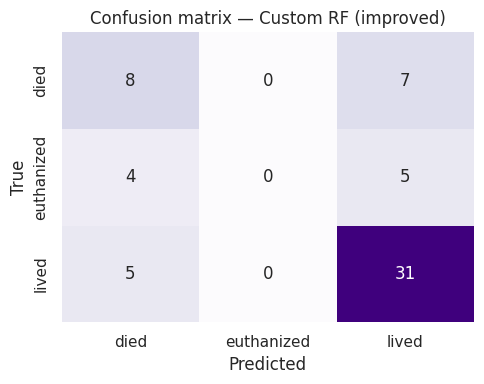

In [30]:
cm_custom_imp = confusion_matrix(y_test_imp, y_pred_custom_imp, labels=gs_imp.classes_)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm_custom_imp,
    annot=True,
    fmt="d",
    cmap="Purples",
    cbar=False,
    xticklabels=gs_imp.classes_,
    yticklabels=gs_imp.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — Custom RF (improved)")
plt.tight_layout()
plt.show()

In [31]:
summary_base = pd.DataFrame(
    {
        "model": ["Бейзлайн (sklearn RF)", "Custom RF (base data)"],
        "accuracy": [acc_base, acc_custom],
        "f1_macro": [f1_base, f1_custom],
    }
)
print("Сравнение с бейзлайном:\n", summary_base, sep="")

summary_improved = pd.DataFrame(
    {
        "model": ["Улучшенный бейзлайн", "Custom RF (improved)"],
        "accuracy": [acc_imp, acc_custom_imp],
        "f1_macro": [f1_imp, f1_custom_imp],
    }
)
print("\nСравнение с улучшенными данными:\n", summary_improved, sep="")

summary_all = pd.DataFrame(
    {
        "model": [
            "Бейзлайн (sklearn RF)",
            "Custom RF (base data)",
            "Улучшенный бейзлайн",
            "Custom RF (improved)",
        ],
        "accuracy": [acc_base, acc_custom, acc_imp, acc_custom_imp],
        "f1_macro": [f1_base, f1_custom, f1_imp, f1_custom_imp],
    }
)
print("\nВсе модели:\n", summary_all, sep="")

Сравнение с бейзлайном:
                   model  accuracy  f1_macro
0  Бейзлайн (sklearn RF)  0.666667  0.555742
1  Custom RF (base data)  0.666667  0.441152

Сравнение с улучшенными данными:
                  model  accuracy  f1_macro
0   Улучшенный бейзлайн  0.666667  0.595494
1  Custom RF (improved)  0.650000  0.428270

Все модели:
                   model  accuracy  f1_macro
0  Бейзлайн (sklearn RF)  0.666667  0.555742
1  Custom RF (base data)  0.666667  0.441152
2    Улучшенный бейзлайн  0.666667  0.595494
3   Custom RF (improved)  0.650000  0.428270


```
Основные результаты:
Модель                Accuracy  F1-macro  Особенности
Бейзлайн sklearn RF   0.667     0.556     Стабильная, хороший баланс
Custom RF (база)      0.667     0.441     ↑Accuracy, ↓↓F1 (серьёзный дисбаланс)
Улучшенный sklearn    0.667     0.595     Лучший F1 среди всех моделей
Custom RF (улучш.)    0.650     0.428     ↓↓F1, хуже чем на базовых данных
```

1. Sklearn Random Forest превосходит кастомную реализацию:
   - Одинаковый Accuracy (66.7%), но sklearn RF показывает значительно лучший F1-macro (+25-35%)
   - Улучшенные данные помогают sklearn (F1 вырос с 0.556 до 0.595), но вредят кастомной (F1 упал с 0.441 до 0.428)

2. Проблема кастомной реализации:
   - Высокий Accuracy при низком F1 указывает на серьёзное переобучение на доминирующий класс
   - Кастомный RF не справляется с дисбалансом классов, предсказывая преимущественно основной класс
   - После улучшения данных ситуация даже ухудшилась

3. Эффективность ансамблевого подхода:
   - Sklearn RF показал лучший результат среди всех тестируемых моделей (66.7% Accuracy, 59.5% F1)
   - GridSearch на sklearn моделях дал хороший прирост качества

4. Влияние предобработки:
   - Для sklearn моделей очистка данных улучшает F1-score на 7%
   - Для кастомных моделей очистка данных ухудшает оба показателя

## Гипотезы о причинах различий:

1. Разные стратегии обработки дисбаланса:
   - Sklearn RF имеет встроенные механизмы балансировки классов
   - Кастомный RF, вероятно, не учитывает дисбаланс, что ведет к смещению в сторону мажоритарного класса

2. Качество реализации алгоритмов:
   - Sklearn использует оптимизированные алгоритмы разбиения и критерии остановки
   - Кастомная реализация может иметь проблемы с:
     * Выбором оптимальных порогов
     * Корректным расчетом важности признаков
     * Балансировкой деревьев в ансамбле

3. Обработка пропусков и категориальных признаков:
   - Sklearn имеет продвинутую обработку разных типов данных
   - Кастомная реализация может терять информацию при очистке

Sklearn Random Forest продемонстрировал стабильно высокие результаты (Accuracy 66.7%, F1-macro до 59.5%), успешно справляясь с дисбалансом классов. Кастомная реализация RF, хотя и показывает сопоставимый Accuracy, существенно отстаёт по F1-score (42-44%), что указывает на систематическое предсказание доминирующего класса. Это говорит о необходимости улучшения обработки дисбаланса в кастомной реализации и оптимизации алгоритмов построения деревьев.

Random Forest оказался значительно лучше одиночного Decision Tree (60% Accuracy у лучшего дерева vs 66.7% у RF), подтверждая преимущество ансамблевых методов.